In [1]:
from model_staging import create_cnn2D, fetch_images_dataframe
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
import keras
from keras import backend as K
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

In [3]:
train_path = "C://Users//Alec//MyPython//Beatles/train_stft"
test_path = "C://Users//Alec//MyPython//Beatles/test_stft"

In [4]:
learning_rate = Real(low=1e-5, high=1.0, prior='log-uniform', name='learning_rate')
epochs = Integer(low=20, high=90, name="epochs")
batch_size = Categorical([8, 16, 24, 40, 64], name="batch_size")
image_dim = Categorical([32, 64, 128, 256], name="image_dim")
conv_layers = Categorical([2, 3, 4, 5], name="conv_layers")
classes = 4

In [5]:
dimensions = [learning_rate, epochs, batch_size, image_dim, conv_layers]
default_parameters = [0.00001, 20, 24, 64, 4]

In [6]:
best_accuracy = 0.0

In [7]:
best_model = "models/stft/skopt_best_adamV3.h5"

In [21]:
@use_named_args(dimensions)
def fitness(learning_rate, epochs, batch_size, image_dim, conv_layers):
    
    global train_df, train_path, classes
    # print the hyperparameters
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('epochs       : {0}'.format(epochs))
    print('batch_size   : {0}'.format(batch_size))
    print('image_dim    : {0}'.format(image_dim))
    print('conv_layers  : {0}'.format(conv_layers))
    
    input_shape = (None, image_dim, image_dim, 3)
    model = create_cnn2D(input_shape, classes, learning_rate=learning_rate, optimizer="Adam")
    
   
    
    train_gen, valid_gen = fetch_images_dataframe(train_df, x_col="song", y_col="artist", directory=train_path,
                                                            batch_size=batch_size, target_size=(image_dim ,image_dim), 
                                                            class_mode="categorical", shuffle=True, seed=1, 
                                                            validation_split=0.2, save_format="png")
    
    steps_per_epoch = np.ceil(train_gen.samples/batch_size)
    validation_steps = np.ceil(valid_gen.samples/batch_size)
    class_weights = [0.25, 0.25, 0.25, 0.25]
    history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=steps_per_epoch,
                                validation_steps=validation_steps, epochs=epochs, class_weight=class_weights)
    
    accuracy = history.history['val_accuracy'][-1]
    print("\nModel accuracy: {0:.2%}\n".format(accuracy))
    
    
    global best_accuracy
    if accuracy > best_accuracy:
        model.save(best_model)
        
        best_accuracy = accuracy
    
    del model
    del train_gen
    del valid_gen
    
    K.clear_session()
    
    return -accuracy

In [22]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [23]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [24]:
search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI', # Expected Improvement.
                                n_calls=40,
                                x0=default_parameters,
                                random_state=1)

learning rate: 1.0e-05
epochs       : 20
batch_size   : 24
image_dim    : 64
conv_layers  : 4
Found 601 validated image filenames belonging to 4 classes.
Found 150 validated image filenames belonging to 4 classes.
Epoch 1/20
26/26 [==============================] - 3s 122ms/step - loss: 1.3219 - accuracy: 0.3844 - val_loss: 1.2912 - val_accuracy: 0.3667
Epoch 2/20
26/26 [==============================] - 2s 62ms/step - loss: 1.2931 - accuracy: 0.3960 - val_loss: 1.7270 - val_accuracy: 0.3667
Epoch 3/20
26/26 [==============================] - 2s 72ms/step - loss: 1.2895 - accuracy: 0.3960 - val_loss: 1.3758 - val_accuracy: 0.3667
Epoch 4/20
26/26 [==============================] - 2s 64ms/step - loss: 1.2921 - accuracy: 0.3960 - val_loss: 1.2337 - val_accuracy: 0.3667
Epoch 5/20
26/26 [==============================] - 2s 65ms/step - loss: 1.2875 - accuracy: 0.3960 - val_loss: 1.1892 - val_accuracy: 0.3667
Epoch 6/20
26/26 [==============================] - 2s 69ms/step - loss: 1.2876 

C:\Users\Alec\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e+00
epochs       : 90
batch_size   : 16
image_dim    : 32
conv_layers  : 2
Found 601 validated image filenames belonging to 4 classes.
Found 150 validated image filenames belonging to 4 classes.
Epoch 1/90
38/38 [==============================] - 2s 53ms/step - loss: 1.3206 - accuracy: 0.3877 - val_loss: 1.3465 - val_accuracy: 0.3667
Epoch 2/90
38/38 [==============================] - 2s 51ms/step - loss: 1.3164 - accuracy: 0.3960 - val_loss: 1.5044 - val_accuracy: 0.3667
Epoch 3/90
38/38 [==============================] - 2s 45ms/step - loss: 1.3103 - accuracy: 0.3960 - val_loss: 1.3651 - val_accuracy: 0.3667
Epoch 4/90
38/38 [==============================] - 2s 46ms/step - loss: 1.3047 - accuracy: 0.3960 - val_loss: 1.2579 - val_accuracy: 0.3667
Epoch 5/90
38/38 [==============================] - 2s 46ms/step - loss: 1.3088 - accuracy: 0.3960 - val_loss: 1.1300 - val_accuracy: 0.3667
Epoch 6/90
38/38 [==============================] - 2s 45ms/step - loss: 1.3029 -

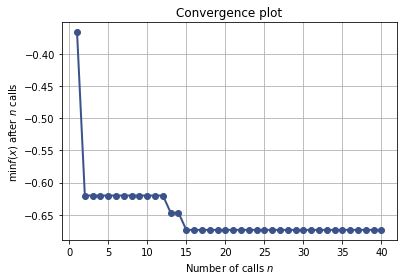

In [25]:
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
plot_convergence(search_result)

In [26]:
# fig = plot_objective_2D(result=search_result,
#                         dimension_name1='learning_rate',
#                         dimension_name2='epochs',
#                         levels=50)

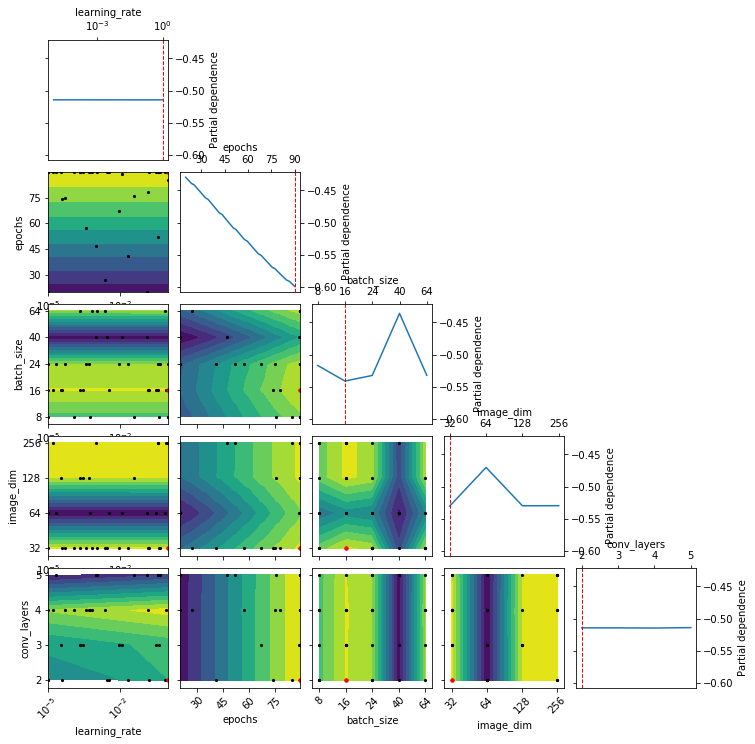

In [27]:
plot_objective(result=search_result);

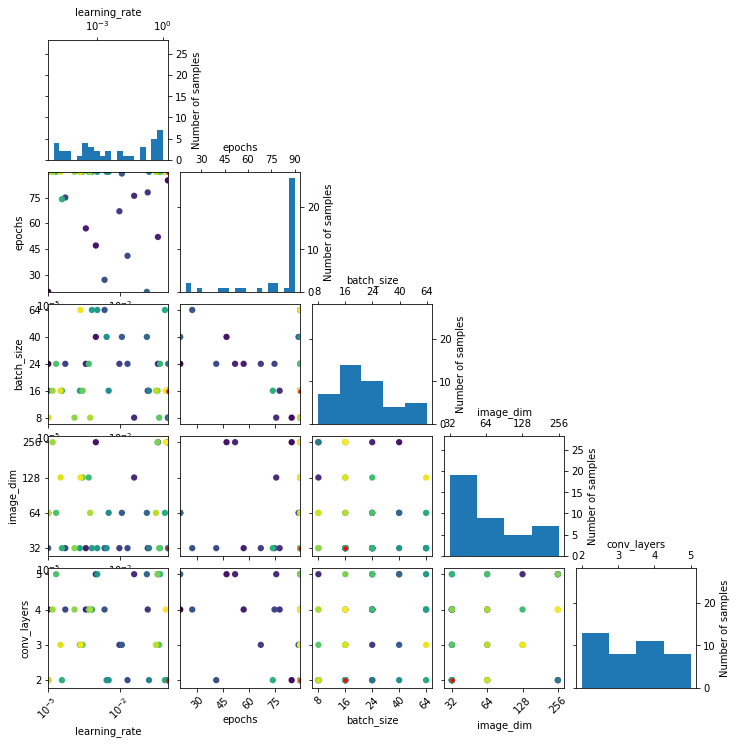

In [28]:
plot_evaluations(result=search_result);

In [29]:
best_params = search_result.x

In [30]:
space = search_result.space

In [31]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.6733333468437195, [1.0, 90, 16, 32, 2]),
 (-0.6666666865348816, [3.2595223826700855e-05, 90, 16, 128, 3]),
 (-0.6600000262260437, [0.7853856465988706, 90, 16, 256, 4]),
 (-0.6466666460037231, [1e-05, 90, 16, 32, 2]),
 (-0.6466666460037231, [0.00027067299867889193, 90, 16, 128, 3]),
 (-0.6399999856948853, [0.1579191734104371, 90, 16, 32, 2]),
 (-0.6399999856948853, [0.45464517624146467, 90, 24, 32, 5]),
 (-0.6333333253860474, [1.5198775445184207e-05, 90, 16, 256, 4]),
 (-0.6266666650772095, [0.0011016158824663095, 90, 64, 32, 5]),
 (-0.6200000047683716, [0.00021858686054498905, 90, 64, 128, 3]),
 (-0.6200000047683716, [0.0006593588799009336, 90, 64, 32, 4]),
 (-0.6200000047683716, [0.13987320840970954, 78, 16, 32, 4]),
 (-0.6200000047683716, [0.3586858931587105, 90, 16, 256, 5]),
 (-0.6200000047683716, [0.9681085478045705, 85, 8, 256, 2]),
 (-0.6133333444595337, [5.135712188714796e-05, 75, 24, 32, 4]),
 (-0.6133333444595337, [0.0002071197893592735, 90, 16, 32, 3]),
 (-0.61333334445

In [32]:
best_model_adam = keras.models.load_model(best_model)

In [33]:
test_gen = fetch_images_dataframe(test_df, x_col="song", y_col="artist", directory=test_path,
                                  batch_size=best_params[2], target_size=(best_params[3], best_params[3]), 
                                  class_mode="categorical", shuffle=False, seed=1, save_format="png")

Found 216 validated image filenames belonging to 1 classes.


In [34]:
probabilities = best_model_adam.predict_generator(test_gen)

In [35]:
preds = np.argmax(probabilities, axis=1)

In [37]:
train_gen, valid_gen = fetch_images_dataframe(train_df, x_col="song", y_col="artist", directory=train_path,
                                              batch_size=best_params[2], target_size=(best_params[3], best_params[3]), 
                                              class_mode="categorical", shuffle=True, seed=1, 
                                              validation_split=0.2, save_format="png")
class_map = train_gen.class_indices

Found 601 validated image filenames belonging to 4 classes.
Found 150 validated image filenames belonging to 4 classes.


In [38]:
pred_df = pd.DataFrame(data={"songs": test_gen.filenames,
                                   "predictions": preds})

In [39]:
mapping = {v:k for k,v in class_map.items()}

In [40]:
pred_df["predictions"] = pred_df["predictions"].map(mapping)

In [41]:
pred_df

,songs,predictions
0,Rock And Roll Music (Remastered 2009)-IRF6nmqc...,starr
1,Good Morning Good Morning (Remastered 2009)-sj...,starr
2,You Never Give Me Your Money (2019 Mix)-W8uZje...,mccartney
3,Being For The Benefit Of Mr. Kite! (Remastered...,harrison
4,Mr Moonlight (Remastered 2009)-FZQ8nWZJrhA.png,harrison
...,...,...
211,Pepperland Laid Waste (Remastered 2009)-JGauvW...,mccartney
212,Think For Yourself (Remastered 2009)-vtx5NTxeb...,starr
213,You Can't Do That (Remastered 2009)-6PK21u7Yzm...,starr
214,Glass Onion (Remastered 2009)-2tSIZLuCKUI.png,mccartney


In [42]:
pred_df.groupby("predictions").count()

,songs
predictions,
Lennon,18
harrison,36
mccartney,120
starr,42


In [43]:
pred_df = pred_df.merge(test_df[["album", "song"]], left_on="songs",right_on="song")
pred_df.drop("song", axis=1, inplace=True)

In [44]:
album_grp = pred_df.groupby(["album", "predictions"]).count()
album_grp.reset_index(inplace=True)
album_grp = album_grp.iloc[:, :3]

In [45]:
pred_df = pred_df.join(pd.DataFrame(probabilities))

In [46]:
mapping

{0: 'Lennon', 1: 'harrison', 2: 'mccartney', 3: 'starr'}

In [47]:
pred_df.rename(mapping, axis=1, inplace=True)

In [48]:
pred_df[['Lennon', 'harrison', 'mccartney', 'starr']] = pred_df[['Lennon', 'harrison', 'mccartney', 'starr']].round(4)

In [49]:
pred_df.head(10)

,songs,predictions,album,Lennon,harrison,mccartney,starr
0,Rock And Roll Music (Remastered 2009)-IRF6nmqc...,starr,BeatlesForSale,0.0000,0.0001,0.0011,0.9988
1,Good Morning Good Morning (Remastered 2009)-sj...,starr,SgtPepper,0.0001,0.0000,0.2977,0.7023
2,You Never Give Me Your Money (2019 Mix)-W8uZje...,mccartney,AbbeyRoad,0.0000,0.0000,1.0000,0.0000
3,Being For The Benefit Of Mr. Kite! (Remastered...,harrison,SgtPepper,0.0001,0.9481,0.0210,0.0309
4,Mr Moonlight (Remastered 2009)-FZQ8nWZJrhA.png,harrison,BeatlesForSale,0.0011,0.9920,0.0025,0.0044
5,Carry That Weight (2019 Mix)-0RagyYjgY4g.png,mccartney,AbbeyRoad,0.0035,0.0098,0.9861,0.0006
6,Dig A Pony (Remastered 2009)-LpdJE7HG8Ls.png,starr,LetItBe,0.0000,0.0031,0.0716,0.9253
7,Baby It's You (Remastered 2009)-AWUTlM6hz0g.png,harrison,PleasePleaseMe,0.0031,0.8780,0.0022,0.1167
8,I'll Be Back (Remastered 2009)-fJSTBNTac6k.png,starr,HardDaysNight,0.0000,0.3751,0.0286,0.5963
9,Don't Bother Me (Remastered 2009)-k03IQbaTcxc.png,harrison,WithTheBeatles,0.0000,0.9921,0.0039,0.0040


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
albums = album_grp["album"].unique()
len(albums)

13

In [52]:
album_grp

,album,predictions,songs
0,AbbeyRoad,Lennon,1
1,AbbeyRoad,harrison,4
2,AbbeyRoad,mccartney,30
3,AbbeyRoad,starr,5
4,BeatlesForSale,harrison,3
5,BeatlesForSale,mccartney,6
6,BeatlesForSale,starr,5
7,HardDaysNight,harrison,2
8,HardDaysNight,mccartney,8
9,HardDaysNight,starr,3


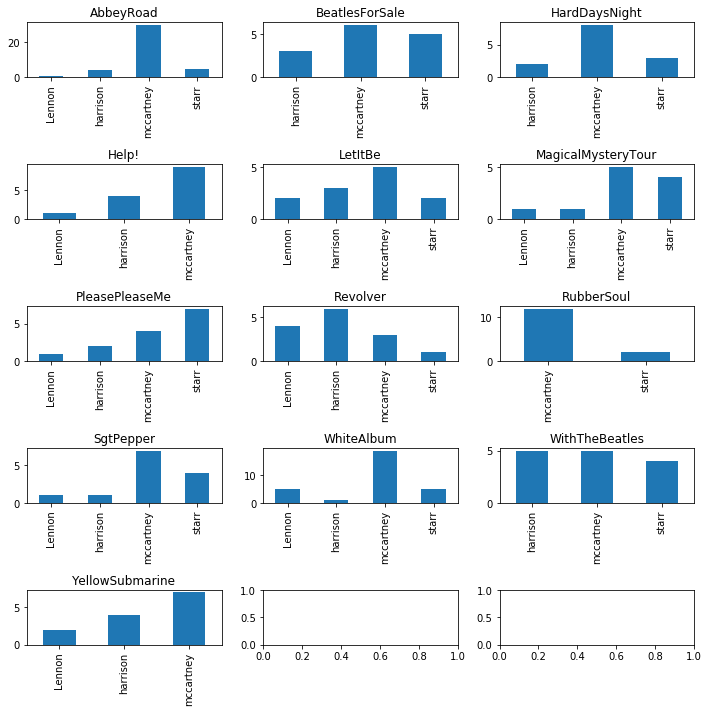

In [53]:
fix, axes = plt.subplots(5, 3, figsize=(10,10))
axes = axes.flatten()
for i, alb in enumerate(albums):
    ax = axes[i]
    album_grp[album_grp["album"] == alb].plot(kind='bar', x='predictions', y='songs', ax=ax, legend=None)
    ax.set_xlabel(None)
    ax.set_title(alb)
    plt.tight_layout()

Text(0.5, 0, '')

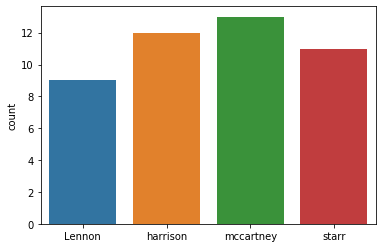

In [54]:
fig, ax = plt.subplots(1,1)
sns.countplot(x="predictions", data=album_grp, ax=ax)
ax.set_xlabel("Lennon")
ax.set_xlabel(None)

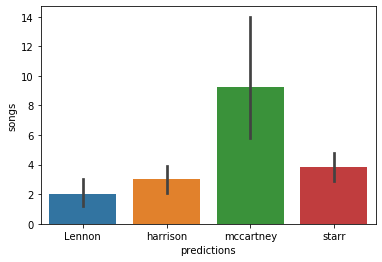

In [55]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Lennon")
ax.set_xlabel(None)
sns.barplot(x="predictions", y="songs", data=album_grp, ax=ax)

In [56]:
#sns.catplot(x="predictions", y="songs", data=album_grp, row="album")

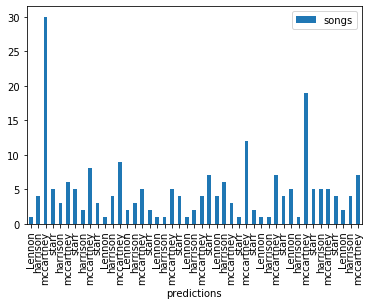

In [57]:
album_grp.plot(kind='bar', x='predictions', y='songs')

In [58]:
album_years = {
    'PleasePleaseMe' : 1963,
    'WithTheBeatles' : 1963,
    'HardDaysNight' : 1964,
    'BeatlesForSale' : 1964,
    'Help!' : 1965,
    'RubberSoul' : 1965,
    'Revolver' : 1966,
    'MagicalMysteryTour': 1967,
    'SgtPepper' : 1967,
    'WhiteAlbum' : 1968,
    'YellowSubmarine' : 1969,
    'AbbeyRoad': 1969,
    'LetItBe' : 1970
}

In [59]:
album_grp["album"].unique()

array(['AbbeyRoad', 'BeatlesForSale', 'HardDaysNight', 'Help!', 'LetItBe',
       'MagicalMysteryTour', 'PleasePleaseMe', 'Revolver', 'RubberSoul',
       'SgtPepper', 'WhiteAlbum', 'WithTheBeatles', 'YellowSubmarine'],
      dtype=object)

In [60]:
album_grp['album_year'] = album_grp['album'].map(album_years)

In [61]:
album_grp

,album,predictions,songs,album_year
0,AbbeyRoad,Lennon,1,1969
1,AbbeyRoad,harrison,4,1969
2,AbbeyRoad,mccartney,30,1969
3,AbbeyRoad,starr,5,1969
4,BeatlesForSale,harrison,3,1964
5,BeatlesForSale,mccartney,6,1964
6,BeatlesForSale,starr,5,1964
7,HardDaysNight,harrison,2,1964
8,HardDaysNight,mccartney,8,1964
9,HardDaysNight,starr,3,1964
